In [1]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import matplotlib.pyplot as plt

In [2]:
# !wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Industrial_and_Scientific.json.gz

In [3]:
# !wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles2/meta_Industrial_and_Scientific.json.gz

In [14]:
!pip install textblob
!pip install pyspark nltk

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 636 kB 18.1 MB/s eta 0:00:01
Defaulting to user installation because normal site-packages is not writeable


# Data Reading

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, length, lower, split, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import when


# Create a Spark session
spark = SparkSession.builder \
    .appName("readGZ") \
    .master("local[*]") \
    .config("spark.default.parallelism", 24) \
    .config("spark.sql.shuffle.partitions", 24) \
    .getOrCreate()

In [5]:

# Read the gzipped JSON file directly into a DataFrame
df = spark.read.json("Industrial_and_Scientific.json.gz")

# Show the DataFrame to check if it's loaded correctly
#df.show(10)

In [6]:
### load the meta data

df_meta = spark.read.json("meta_Industrial_and_Scientific.json.gz")
#df_meta.show(10)

## Discussion



1.   We can not read some categories (especially those with large data, in this case, the sofrware category) directly in Spark; Need to figure out why and how to solve this. (Tried reading by in raw and use pandas and then spark, but this also failed.)
(I skipped this question by choosing another category which is fine to read directly)





# Data Pre-Processing and visulization

In [7]:
# summarize the nulls in dataframe
for column in df.columns:
    # Calculate the number of nulls in the column
    null_count = df.filter(col(column).isNull()).count()
    
    # Calculate the percentage of nulls
    null_percentage = (null_count / df.count()) * 100
    
    # Print the results
    print(f"Number of Nulls in {column}: {null_count}, Percentage: {null_percentage:.2f}%")


Number of Nulls in asin: 0, Percentage: 0.00%
Number of Nulls in image: 1725623, Percentage: 98.14%
Number of Nulls in overall: 0, Percentage: 0.00%
Number of Nulls in reviewText: 984, Percentage: 0.06%
Number of Nulls in reviewTime: 0, Percentage: 0.00%
Number of Nulls in reviewerID: 0, Percentage: 0.00%
Number of Nulls in reviewerName: 110, Percentage: 0.01%
Number of Nulls in style: 1066819, Percentage: 60.67%
Number of Nulls in summary: 403, Percentage: 0.02%
Number of Nulls in unixReviewTime: 0, Percentage: 0.00%
Number of Nulls in verified: 0, Percentage: 0.00%
Number of Nulls in vote: 1552025, Percentage: 88.27%


In [8]:
# Drop the image, style, vote columns
df = df.drop('image', 'style', 'vote')


In [9]:
from pyspark.sql.functions import col, when, length, unix_timestamp, to_date

# Handling missing values: For simplicity, we'll drop rows with any NULLs
df = df.na.drop()

# Filtering out unverified reviews
df = df.filter(col('verified') == True)

# Feature Engineering - creating a new feature for the length of the reviewText
df = df.withColumn('reviewText_length', length(col('reviewText')))


In [10]:
df.count()

1635211

In [11]:
review_lengths = df.select('reviewText_length').rdd.flatMap(lambda x: x).collect()

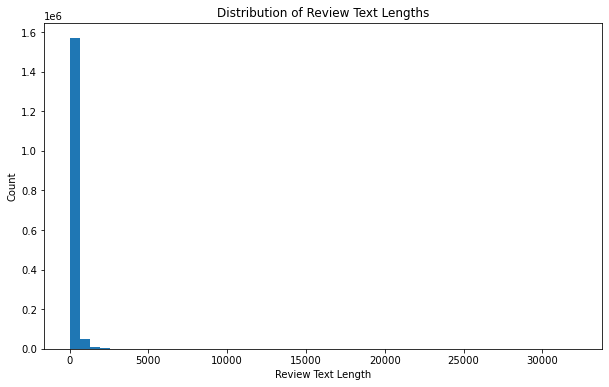

In [12]:
# Now convert this list to a Pandas Series
pd_series = pd.Series(review_lengths)

# Plotting the distribution of reviewText_length using Pandas/Matplotlib
plt.figure(figsize=(10, 6))
pd_series.hist(bins=50)  # Adjust the number of bins for your specific dataset
plt.title('Distribution of Review Text Lengths')
plt.xlabel('Review Text Length')
plt.ylabel('Count')
plt.grid(False)
plt.show()

In [15]:
# Example of filtering based on a condition, such as reviews that are too short/long might be outliers
df = df.filter(col('reviewText_length') > 10)  # Example threshold
df = df.filter(col('reviewText_length') < 1000)  # Example threshold

## Text Processing

In [16]:
# Text Processing - cleaning the review text, undercase the words, tokenizing, and removing stop words (simplified example)
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, FloatType
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')

# Define a UDF for sentiment analysis
def get_sentiment(text):
    analysis = TextBlob(str(text))
    # Classify the polarity of the text
    # You can customize this based on your needs
    if analysis.sentiment.polarity > 0:
        return "positive"
    elif analysis.sentiment.polarity == 0:
        return "neutral"
    else:
        return "negative"
    
def analyze_sentiment(review_text):
    sid = SentimentIntensityAnalyzer()
    sentiment_score = sid.polarity_scores(review_text)['compound']
    return sentiment_score

sentiment_analysis_udf = udf(analyze_sentiment, FloatType())
df = df.withColumn("sentiment_score", sentiment_analysis_udf(df["reviewText"]))



# Register the UDF
sentiment_udf = udf(get_sentiment, StringType())

# Apply sentiment analysis to the 'reviewText' column
df = df.withColumn("sentiment", sentiment_udf("reviewText"))


df = df.withColumn('reviewText', lower(col('reviewText'))) 
tokenizer = Tokenizer(inputCol='reviewText', outputCol='reviewText_tokens')
df = tokenizer.transform(df)
remover = StopWordsRemover(inputCol='reviewText_tokens', outputCol='reviewText_clean')
df = remover.transform(df)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ynx9zm/nltk_data...


In [17]:
# Split reviewTime into day, month, and year
split_col = split(df['reviewTime'], ' ')
df = df.withColumn('Day', split_col.getItem(0))
df = df.withColumn('Month', split_col.getItem(1).substr(0,2))
df = df.withColumn('Year', split_col.getItem(2))
df = df.drop('reviewTime')

In [13]:
df.select('reviewerName').distinct().count()

695174

In [14]:
df.select('asin').distinct().count()

154300

In [15]:
from pyspark.sql.functions import avg, count

# Average rating
average_rating = df.agg(avg("overall")).first()[0]

# Count of reviews for each asin
reviews_per_asin = df.groupBy("asin").agg(count("reviewerID").alias("Number_of_Reviews"))

In [16]:
# Count of reviews for each reviewer
reviews_per_reviewers = df.groupBy("reviewerID").agg(count("asin").alias("Number_of_Reviews"))

In [17]:
# Convert Spark DataFrame to Pandas for Visualization
pdf = df.toPandas()
reviews_per_asin_pdf = reviews_per_asin.toPandas()

# Histogram for overall ratings
plt.figure(figsize=(10, 6))
pdf['overall'].hist()
plt.title('Distribution of Overall Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(False)
plt.show()

# Plotting the pie chart for overall ratings
rating_counts = pdf['overall'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Overall Ratings')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 56078)
Traceback (most recent call last):
  File "/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/socketserver.py", line 720, in __init__
    self.handle()
  File "/home/ynx9zm/.local/lib/python3.8/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/home/ynx9zm/.local/lib/python3.8/site-packages/pyspark

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
# Bar chart for number of reviews for each asin
top_reviews_per_asin_pdf = reviews_per_asin_pdf.sort_values(by='Number_of_Reviews', ascending=False).head(100)
plt.figure(figsize=(10, 6))
# Set the 'asin' as the index and plot the 'review_count' column
top_reviews_per_asin_pdf.set_index('asin')['Number_of_Reviews'].plot(kind='bar', legend=False)
plt.title('Number of Reviews for Top 100 ASINs')
plt.ylabel('Count')
plt.xlabel('ASIN')
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# Bar chart for number of reviews for each reviewers
reviews_per_reviewers_pdf = reviews_per_reviewers.toPandas()

top_reviews_per_reviewers_pdf = reviews_per_reviewers_pdf.sort_values(by='Number_of_Reviews', ascending=False).head(100)
plt.figure(figsize=(10, 6))
# Set the 'reviewers' as the index and plot the 'review_count' column
top_reviews_per_reviewers_pdf.set_index('reviewerID')['Number_of_Reviews'].plot(kind='bar', legend=False)
plt.title('Number of Reviews for Top 100 reviewers')
plt.ylabel('Count')
plt.xlabel('reviewers')
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# Convert reviewText and summary columns to a single string
review_text_str = ' '.join(df.rdd.map(lambda row: row.reviewText).collect())
summary_str = ' '.join(df.rdd.map(lambda row: row.summary).collect())

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_word_cloud(review_text_str, "Word Cloud for Review Text")
generate_word_cloud(summary_str, "Word Cloud for Summary")


# Modelling

## Data Splitting

In [20]:
###sampling
sampled_df = df.sample(fraction=0.01, seed=42)
sampled_df.count()

15233

In [28]:
from pyspark.ml.feature import StringIndexer

# Indexing is required to convert string identifiers to numeric indices for the ALS algorithm
indexer_user = StringIndexer(inputCol="reviewerID", outputCol="userIndex")
df = indexer_user.fit(sampled_df).transform(sampled_df)

indexer_item = StringIndexer(inputCol="asin", outputCol="itemIndex")
df = indexer_item.fit(df).transform(df)

In [29]:
(train, test) = df.randomSplit([0.8, 0.2])


## ALS

refer: https://www.kaggle.com/code/nadianizam/h-m-fashion-recommendation-with-pyspark



In [30]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Setting up the ALS model
als = ALS(maxIter=5, regParam=0.01, userCol="userIndex", itemCol="itemIndex", ratingCol="overall", coldStartStrategy="drop")

In [32]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [33]:
# Fit the ALS model to the training data
model = als.fit(train)

# Get the number of iterations
num_iterations = model._java_obj.parent().getMaxIter()

# Create an RMSE evaluator using the label and predicted columns
reg_evaluator = RegressionEvaluator(metricName="rmse", labelCol="overall", predictionCol="prediction")

# Create tqdm wrapper for the range of iterations
for epoch in tqdm(range(num_iterations), desc="Training ALS Model"):
    # Train the model for one iteration (you may need to adjust this depending on your needs)
    model._java_obj.parent().setNumBlocks(10).setMaxIter(epoch + 1)
    model = als.fit(train)

    # Predict on the train and test sets
    predictions_train = model.transform(train)
    predictions_test = model.transform(test)

    # Evaluate the model on training data
    rmse_train = reg_evaluator.evaluate(predictions_train)

    # Evaluate the model on test data
    rmse_test = reg_evaluator.evaluate(predictions_test)

    # Optionally print or log the RMSE values for each iteration
    print(f"Iteration {epoch + 1}: RMSE (Train) = {rmse_train:.4f}, RMSE (Test) = {rmse_test:.4f}")

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/home/ynx9zm/.local/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/ynx9zm/.local/lib/python3.8/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [31]:
# Fitting the ALS model on the training data
model = als.fit(train)

# Predicting on the train and test sets
predictions_train = model.transform(train)
predictions_test = model.transform(test)

# Create an RMSE evaluator using the label and predicted columns
reg_evaluator = RegressionEvaluator(metricName="rmse", labelCol="overall", predictionCol="prediction")

# Evaluate the model on training data
rmse_train = reg_evaluator.evaluate(predictions_train)

# Evaluate the model on test data
rmse_test = reg_evaluator.evaluate(predictions_test)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/home/ynx9zm/.local/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/ynx9zm/.local/lib/python3.8/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [22]:
#grid search for ALS model

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [10, 20, 30]) \
    .addGrid(als.maxIter, [5, 10, 15]) \
    .addGrid(als.regParam, [0.01, 0.1, 1.0]) \
    .build()


##cross validation
cross_val = CrossValidator(
    estimator=als,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=5
)

In [ ]:
cv_model = cross_val.fit(train_data)


In [ ]:
best_model = cv_model.bestModel
best_model.save("models/Best_RatingALSModel.obj")

In [ ]:
model.recommendForAllUsers(10).show(1, truncate = False)
model.save("models/RatingALSModel.obj")

In [ ]:
rmse_train

In [ ]:
rmse_test

## Recall

In [ ]:
from pyspark.ml.recommendation import ALSModel
recommendnum = 10
als_model = ALSModel.load("models/RatingALSModel.obj")
als_model.recommendForAllUsers(recommendnum).show(1)

In [ ]:
train.groupBy("userIndex").count().count()

In [ ]:
train.filter(train['userIndex'] == testUserID).select('itemIndex').show(10)

In [ ]:
train.select('userIndex').show(1)

In [ ]:
df_temp = als_model.recommendForAllUsers(10)

In [ ]:
x = df_temp.select('recommendations').collect()

In [ ]:
from pyspark.sql.functions import col,explode
df_temp0 = df_temp.withColumn("name", explode(col('recommendations')))
df_temp0.withColumn("name2", col('name').getItem(0)).show(10)

In [ ]:
from pyspark.sql.functions import col,expr
df_temp0 = df_temp.withColumn("name", expr("transform(recommendations, r -> r.itemIndex)"))
df_temp0.show(10)

In [ ]:
train.filter(train['userIndex'] == m.userIndex).select('itemIndex')

In [ ]:
from pyspark.sql.functions import collect_list
actualitem = train.groupby('userIndex').agg(collect_list('itemIndex').alias('indexlist'))

In [ ]:
result = df_temp0.join(actualitem, 'userIndex')

In [ ]:
from pyspark.sql.functions import array_intersect, size, avg
metrics = result.withColumn('TP', size(array_intersect(col('name'),col('indexlist')))) \
                .withColumn('precision', col('TP')/recommendnum) \
                .withColumn('recall', col('TP')/size(col('indexlist'))) \
                .withColumn('F1', when((col('precision') + col('recall')) >0,
                                        2* (col('precision') *col('recall'))/(col('precision') +col('recall')))
                             .otherwise(0))

In [ ]:
from pyspark.sql.functions import max as ma
average_metrics = metrics.agg(
    ma(col('precision')),
    ma(col('recall')),
    ma(col('F1'))
)
average_metrics.show()

In [ ]:
metrics.show()

In [ ]:
df_temp0.withColumn("name2", col('name').getItem(0))

In [ ]:
for r in als_model.userFactors.select("id").collect():
    userId = r.id
    cateId_df = pd.DataFrame(pdf.cateId,unique(),columns=['cateId'])
    cateId_df.insert(0,'userId',np.array([userId for i in range(6769)]))

    ret = set()
    # 利用模型，传入datasets(userId, cateId)，这里控制了userId一样，所以相当于是在求某用户对所有分类的兴趣程度
    cateId_list = als_model.transform(spark.createDataFrame(cateId_df)).sort('prediction',ascending=False).na.drop()
   
    # 从前20个分类中选出500个进行召回
    for i in cateId_list.head(20):
        need = 500 - len(ret)    # 如果不足500个，那么随机选出need个广告
        ret = ret.union(np.random.choice(pdf.where(pdf.cateId==i.cateId).adgroupId.dropna().astype(np.int64),need))
        if len(ret) >= 500:    # 如果达到500个则退出
            break
    client.sadd(userId, *ret)     

## GraphFrame

In [ ]:
!pip install graphframes

In [ ]:
from graphframes import GraphFrame

# Assuming 'df' is your original PySpark DataFrame and it has been indexed
# Create vertices DataFrame
vertices = df.selectExpr("userIndex as id").distinct().union(df.selectExpr("itemIndex as id").distinct()) # check if those two index overlap

# Create edges DataFrame
edges = df.selectExpr("userIndex as src", "itemIndex as dst", "overall as rating")

# Create a GraphFrame
graph = GraphFrame(vertices, edges)

In [ ]:
# TO DO
# 1: Hyperparameter tuning
# 2: How to make use of the graph functions?

# Meta Data

In [ ]:
df_meta.printSchema()

In [ ]:
print("item总数：", df_meta.groupBy("asin").count().count())
print("brand总数：", df_meta.groupBy("brand").count().count())
print("category总数：", df_meta.groupBy("category").count().count())

In [ ]:
print("分类特征值个数情况: ")
print("cms_segid: ", user_profile_df.groupBy("cms_segid").count().count())
print("cms_group_id: ", user_profile_df.groupBy("cms_group_id").count().count())
print("final_gender_code: ", user_profile_df.groupBy("final_gender_code").count().count())
print("age_level: ", user_profile_df.groupBy("age_level").count().count())
print("shopping_level: ", user_profile_df.groupBy("shopping_level").count().count())
print("occupation: ", user_profile_df.groupBy("occupation").count().count())

print("含缺失值的特征情况: ")
df_meta.groupBy("details").count().show()
df_meta.groupBy("feature").count().show()
df_meta.groupBy("fit").count().show()

t_count = df_meta.count()

pl_na_count = t_count - user_profile_df.dropna(subset=["pvalue_level"]).count()
print("pvalue_level的空值情况：", pl_na_count, "空值占比：%0.2f%%"%(pl_na_count/t_count*100))

nul_na_count = t_count - user_profile_df.dropna(subset=["new_user_class_level"]).count()
print("new_user_class_level的空值情况：", nul_na_count, "空值占比：%0.2f%%"%(nul_na_count/t_count*100))


In [ ]:
print("含缺失值的特征情况: ")
df_meta.groupBy("details").count().show()
df_meta.groupBy("feature").count().show()
df_meta.groupBy("fit").count().show()

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/ynx9zm/.local/lib/python3.8/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ynx9zm/.local/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/ynx9zm/.local/lib/python3.8/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
